In [1]:
# Inport library

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.algorithms import VQR
from qiskit.algorithms.optimizers import L_BFGS_B
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import time

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_43097/2255241282.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import L_BFGS_B


In [2]:
df = pd.read_csv(".././data/cleanDataset.csv")
df.head()

,Molecular Weight (g/mol),pKa,Log P,Log S,Polar Surface Area (Å2),Polarizability (Å3),HOMO (eV),LUMO (eV),Ionization Energy (eV),Electron Affinity (eV),Electronegativity (eV),Hardness (eV),Electrophilicity (eV),ΔN_Fe,IE (%)
0,194.19,14.00,-0.07,-0.97,58.44,18.96,-5.769,-1.977,5.769,1.977,3.873,1.896,0.96825,0.824631,92.0
1,151.16,9.90,0.91,-1.60,49.33,15.52,-5.494,-1.646,5.494,1.646,3.570,1.924,0.89250,0.891372,85.8
2,222.30,8.80,-0.26,-2.36,115.04,19.16,-7.010,-3.358,7.010,3.358,5.184,1.826,1.29600,0.497262,93.0
3,60.05,4.80,-0.17,1.22,37.30,5.34,-6.816,-1.070,6.816,1.070,3.943,2.873,0.98575,0.532022,92.0
4,137.14,3.38,0.83,-0.40,63.32,13.44,-5.922,-2.122,5.922,2.122,4.022,1.900,1.00550,0.783684,80.0


In [3]:
X = df.drop("IE (%)", axis=1)
y = df["IE (%)"]

In [4]:
minMaxScaler = MinMaxScaler()
X_scaled = minMaxScaler.fit_transform(X)

In [5]:
# Apply PCA
num_components = 0.95  # Choose the number of components you want to keep
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape[1]

5

In [6]:
y = y.to_numpy()
y = y.reshape(-1,1)

In [7]:
algorithm_globals.random_seed = 2
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=algorithm_globals.random_seed)

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_43097/4246028653.py:1: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0 release. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 2
/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_43097/4246028653.py:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0 release. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.util

In [8]:
num_qubit = X_train.shape[1]

In [9]:
"""# Construct feature map with 5 qubits
feature_map = QuantumCircuit(num_qubit, name="fm")
for i in range(num_qubit):
    feature_map.ry(Parameter(f"x{i}"), i)
# Tambahkan entangler
for i in range(num_qubit):
    feature_map.cx(i, (i + 1) % num_qubit)"""


num_featrue = X_train.shape[1]
feature_map = PauliFeatureMap(feature_dimension=num_featrue, reps=1)

In [10]:
# Construct ansatz with 5 qubits
ansatz = QuantumCircuit(num_qubit, name="vf")
# Buat parameter untuk rotasi pada setiap qubit

alfas = [Parameter(f'α_{i}') for i in range(num_qubit)]
betas = [Parameter(f'β_{i}') for i in range(num_qubit)]
gammas = [Parameter(f'γ_{i}') for i in range(num_qubit)]

for i in range(num_qubit):
    ansatz.ry(Parameter(f"y{i}"), i)
# Tambahkan entangler
for i in range(num_qubit):
    ansatz.cx(i, (i + 1) % num_qubit)
for i in range(num_qubit):
    ansatz.rx(alfas[i], i)
for i in range(num_qubit):
    ansatz.ry(betas[i], i)
"""for i in range(num_qubit):
    ansatz.rz(gammas[i], i)"""

'for i in range(num_qubit):\n    ansatz.rz(gammas[i], i)'

In [11]:
"""# Kompilasi sirkuit
parameter_values = {alfas[i]: 0.1 for i in range(num_qubit)}
parameter_values.update({betas[i]: 0.2 for i in range(num_qubit)})
parameter_values.update({gammas[i]: 0.3 for i in range(num_qubit)})
ansatz = ansatz.bind_parameters(parameter_values)"""

'# Kompilasi sirkuit\nparameter_values = {alfas[i]: 0.1 for i in range(num_qubit)}\nparameter_values.update({betas[i]: 0.2 for i in range(num_qubit)})\nparameter_values.update({gammas[i]: 0.3 for i in range(num_qubit)})\nansatz = ansatz.bind_parameters(parameter_values)'

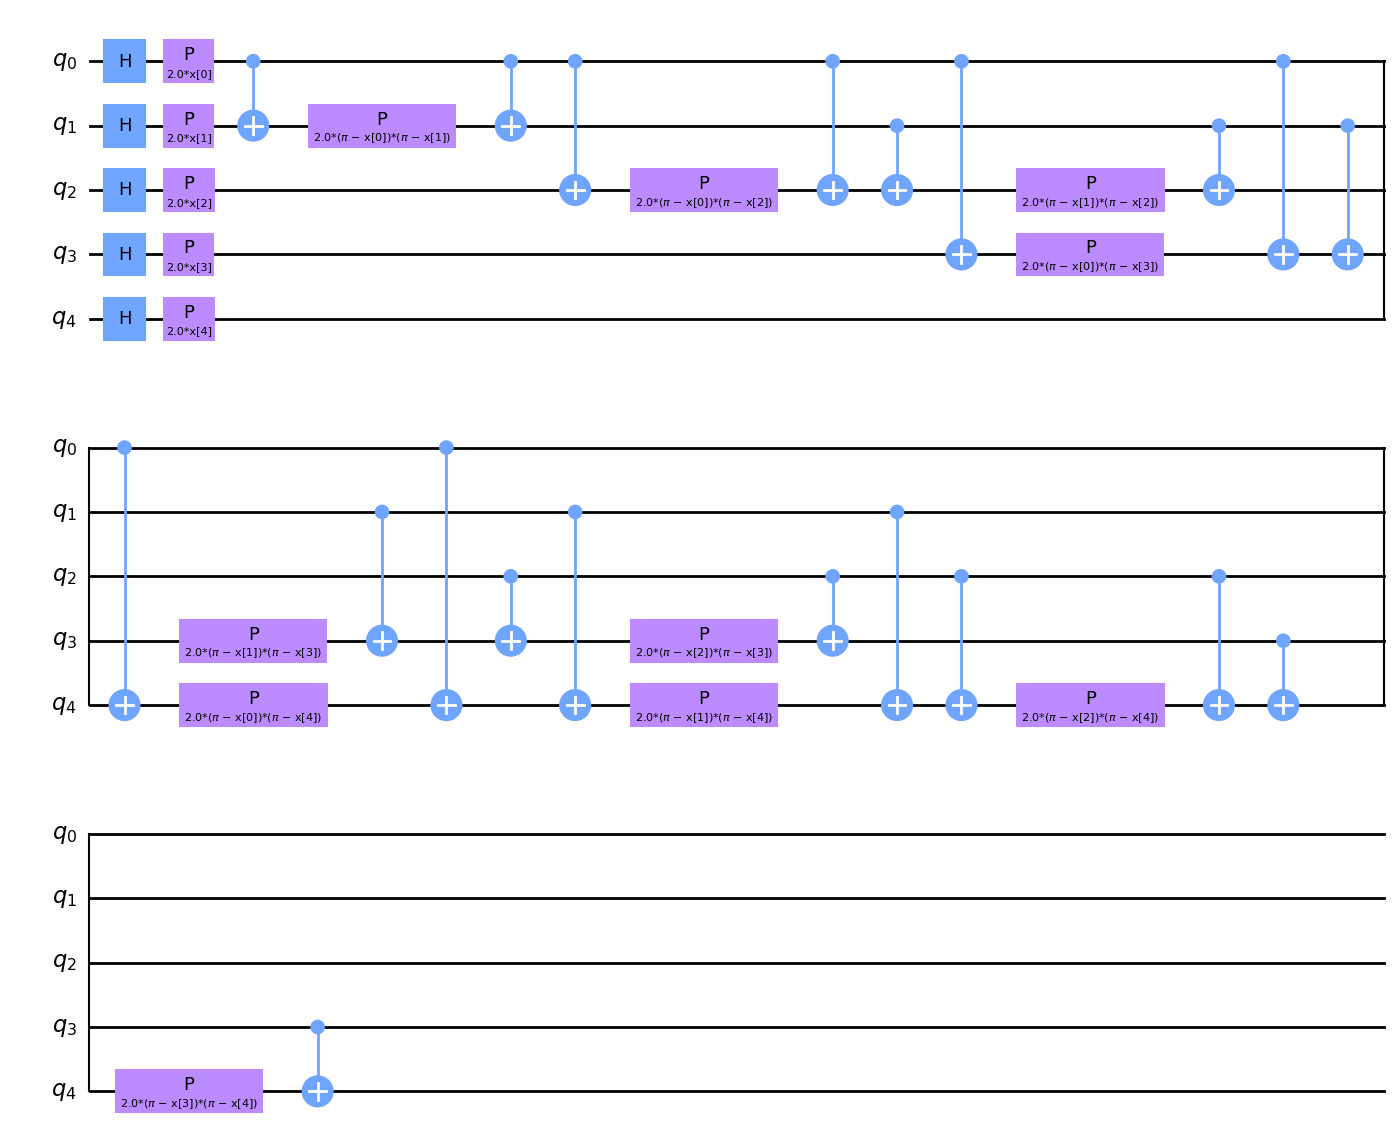

In [12]:
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

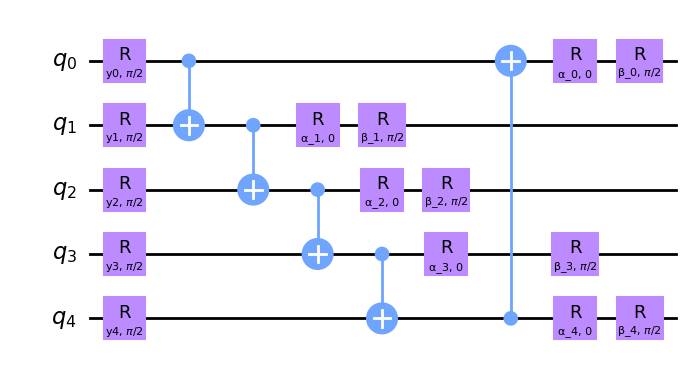

In [13]:
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [14]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=20),
    callback=callback_graph,
)

In [16]:
# Pastikan X_train dan y_train sesuai dengan format yang diharapkan
X_train = np.array(X_train)  # pastikan X_train berupa array numpy
y_train = np.array(y_train)  # pastikan y_train berupa array numpy

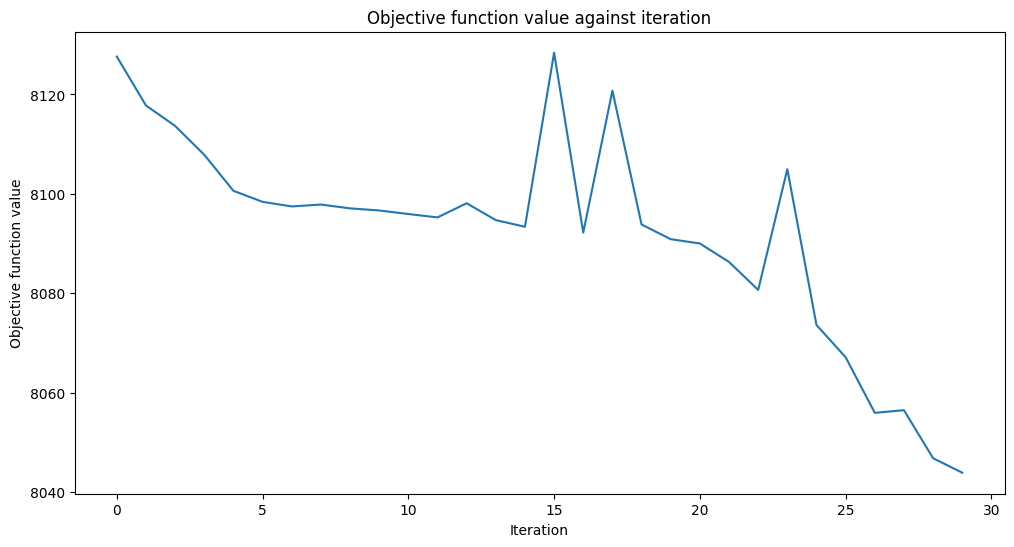

Training time: 94 seconds


In [17]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# clear objective value history
objective_func_vals = []

start = time.time()
vqr.fit(X_train, y_train.ravel())
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [18]:
y_pred = vqr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)

print(f"Training time: {round(elapsed)} seconds")
print(f'MSE: {mse}')
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {rsquare}")

Training time: 94 seconds
MSE: 7707.135575027817
RMSE: 87.79029317087293
MAPE: 0.9917934284980812
R2: -112.11746003615217


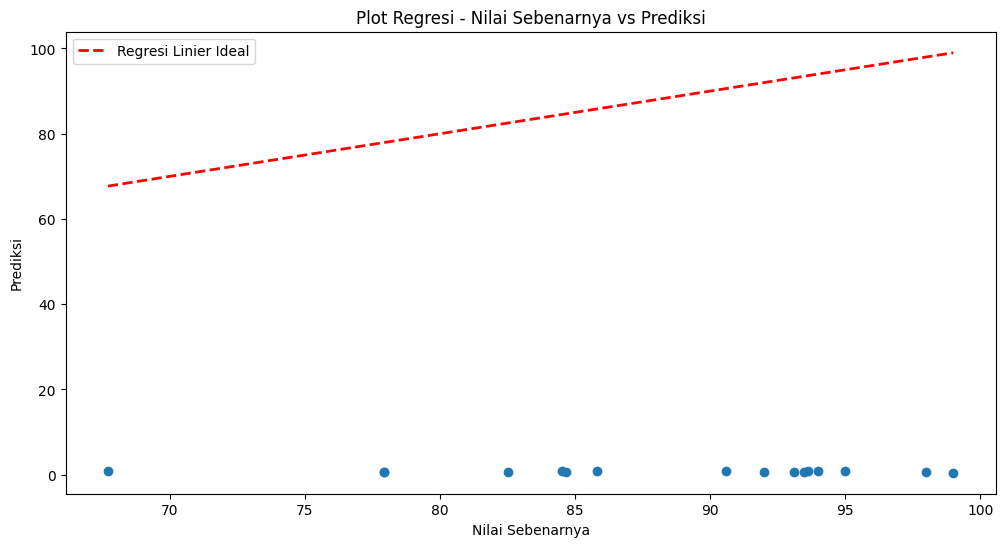

In [19]:
# Plot prediksi vs nilai sebenarnya pada data uji
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Regresi Linier Ideal')
plt.title('Plot Regresi - Nilai Sebenarnya vs Prediksi')
plt.xlabel('Nilai Sebenarnya')
plt.ylabel('Prediksi')
plt.legend()
plt.show()